In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import backend as K
import gc

In [3]:
import tensorflow as tf
from tensorflow.python.platform import build_info as tf_build_info

print("TensorFlow:", tf.__version__)
print("CUDA version:", tf_build_info.build_info.get("cuda_version", "n/a"))
print("cuDNN version:", tf_build_info.build_info.get("cudnn_version", "n/a"))
print("Available GPUs:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.10.0
CUDA version: 64_112
cuDNN version: 64_8
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from pathlib import Path
import tensorflow as tf

# If you run scripts from the PR-CNN folder:
# base = Path.cwd()

# Or set your project root explicitly:
base = Path(r"C:\Users\Asus\Desktop\PR-CNN")

data_dir = base / "PatternProject" / "Data" / "RealWaste"
print("CWD:", Path.cwd())
print("Looking for:", data_dir)
print("Exists?", data_dir.exists())
print("Sample list:", list(data_dir.glob("*"))[:5])  # should show class subfolders

# Must be: RealWaste/<class1>/*.jpg, RealWaste/<class2>/*.png, ...
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
)


CWD: c:\Users\Asus\Desktop\PR-CNN\PatternProject
Looking for: C:\Users\Asus\Desktop\PR-CNN\PatternProject\Data\RealWaste
Exists? True
Sample list: [WindowsPath('C:/Users/Asus/Desktop/PR-CNN/PatternProject/Data/RealWaste/Cardboard'), WindowsPath('C:/Users/Asus/Desktop/PR-CNN/PatternProject/Data/RealWaste/Food Organics'), WindowsPath('C:/Users/Asus/Desktop/PR-CNN/PatternProject/Data/RealWaste/Glass'), WindowsPath('C:/Users/Asus/Desktop/PR-CNN/PatternProject/Data/RealWaste/Metal'), WindowsPath('C:/Users/Asus/Desktop/PR-CNN/PatternProject/Data/RealWaste/Miscellaneous Trash')]
Found 4752 files belonging to 9 classes.


### loading the dataset as a tf.data.dataset object

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory=r"C:\Users\Asus\Desktop\PR-CNN\PatternProject\Data\RealWaste",
    batch_size=32,
    image_size=(256,256),     #resizing
    shuffle=True,
    seed=123
) 

Found 4752 files belonging to 9 classes.


In [6]:
dataset.class_names

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

(32, 256, 256, 3)
(32,)


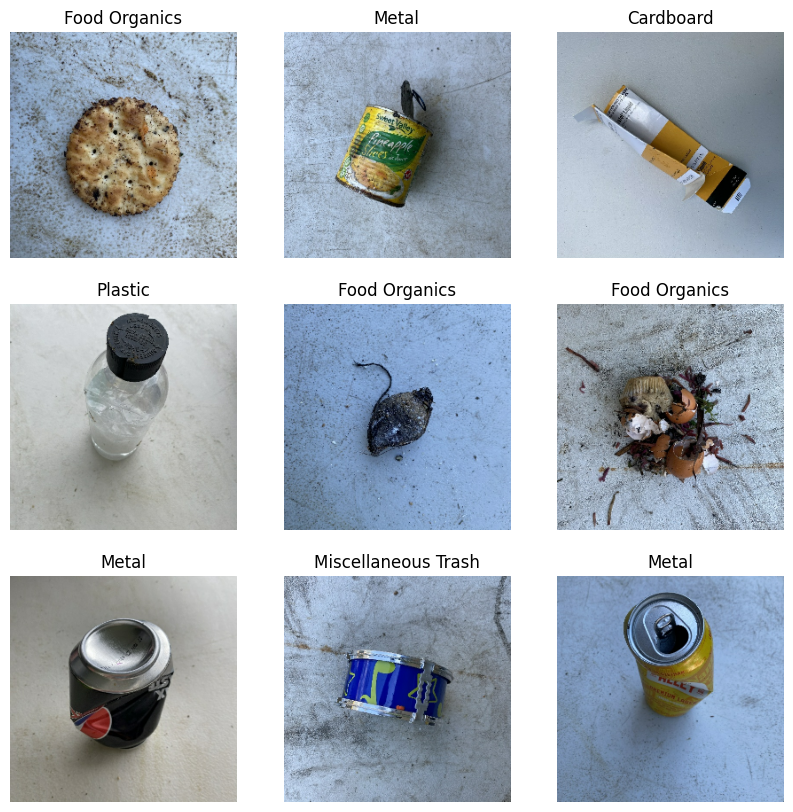

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):

  print(images.shape)
  print(labels.shape)

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(dataset.class_names[labels[i]])
    plt.axis("off")
    

In [8]:
len(dataset)

149

In [9]:
train_dataset=dataset.take(105)
remaining=dataset.skip(105)

print(f"Percentage of traning set {round(((len(train_dataset)/len(dataset))*100))} %")
print(f"Percentage of test set {round(((len(remaining)/len(dataset))*100))} %")


Percentage of traning set 70 %
Percentage of test set 30 %


In [10]:
test_dataset=remaining.take(22)
cv_dataset=remaining.skip(22)
print(f"Percentage of traning set {round(((len(test_dataset)/len(dataset))*100))} %")
print(f"Percentage of test set {round(((len(cv_dataset)/len(dataset))*100))} %")

Percentage of traning set 15 %
Percentage of test set 15 %


In [11]:
test_dataset.save('saved_datasets/test_dataset')
train_dataset.save('saved_datasets/train_dataset')
cv_dataset.save('saved_datasets/cv_dataset')

In [12]:
train_dataset = tf.data.Dataset.load('saved_datasets/train_dataset')
cv_dataset = tf.data.Dataset.load('saved_datasets/cv_dataset')
test_dataset = tf.data.Dataset.load('saved_datasets/test_dataset')

In [13]:
def class_counts(dataset, num_classes):
    counts = np.zeros(num_classes, dtype=int)
    for _, labels in dataset.unbatch():      # unbatch = go sample-by-sample
        if len(labels.shape) == 0:           
            counts[labels.numpy()] += 1
        else:                                # one-hot labels
            counts[np.argmax(labels.numpy())] += 1
    return counts

In [14]:
#dataset_counts = class_counts(dataset, 9)
#dataset_counts

In [15]:
#train_counts = class_counts(train_dataset, 9)
#train_counts

In [16]:
#test_counts = class_counts(test_dataset, 9)
#test_counts

In [17]:
#cv_counts = class_counts(cv_dataset, 9)
#cv_counts

In [18]:
from keras import Sequential
from keras.layers import Resizing, Rescaling, RandomRotation, RandomFlip , Dropout , RandomZoom , RandomTranslation , BatchNormalization
from keras.callbacks import ReduceLROnPlateau ,EarlyStopping

rescale_resize=Sequential([
    Rescaling(1.0/255),
    Resizing(128,128)
])

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.10),      
    RandomZoom(0.10),         
    RandomTranslation(0.10, 0.10), 
])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True
)


In [19]:
from keras import layers
model = Sequential([
    rescale_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    Dropout(0.5),
    
    layers.Dense(128, activation='relu'),
    Dropout(0.3),
    
    layers.Dense(9, activation='softmax'),
])

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model (a clone of model_8, except to be multi-class)
model_9 = Sequential([
  rescale_resize,
  data_augmentation,
  Conv2D(10, 3, activation='relu', input_shape=(128,128,3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(16, activation='relu'),
  Dense(9, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_9.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [21]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

model_9.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [23]:
history = model_9.fit(
    train_dataset,
    epochs=20,
    validation_data=cv_dataset,
    callbacks=[reduce_lr, early_stop] 
)

Epoch 1/20
105/105 [==============================] - 42s 400ms/step - loss: 1.0134 - accuracy: 0.6277 - val_loss: 1.0602 - val_accuracy: 0.6177 - lr: 0.0010
Epoch 2/20
105/105 [==============================] - 45s 431ms/step - loss: 0.9674 - accuracy: 0.6497 - val_loss: 1.0771 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 3/20
105/105 [==============================] - 43s 414ms/step - loss: 0.9753 - accuracy: 0.6440 - val_loss: 1.0590 - val_accuracy: 0.6279 - lr: 0.0010
Epoch 4/20
105/105 [==============================] - 26s 249ms/step - loss: 0.9237 - accuracy: 0.6661 - val_loss: 1.0589 - val_accuracy: 0.6221 - lr: 0.0010
Epoch 5/20
105/105 [==============================] - 27s 254ms/step - loss: 0.9391 - accuracy: 0.6601 - val_loss: 1.0286 - val_accuracy: 0.6192 - lr: 0.0010
Epoch 6/20
105/105 [==============================] - 26s 252ms/step - loss: 0.9326 - accuracy: 0.6625 - val_loss: 1.0772 - val_accuracy: 0.6308 - lr: 0.0010
Epoch 7/20
105/105 [==============================] 

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

rescale_resize = keras.Sequential([
    layers.Rescaling(1/255.0),
    layers.Resizing(128, 128)
])

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.10),
    layers.RandomZoom(0.10),
    layers.RandomTranslation(0.10, 0.10),
])

inputs = keras.Input(shape=(None, None, 3))
x = rescale_resize(inputs)
x = data_augmentation(x)

# ↑ Keep augmentation AFTER rescaling (these layers expect float in [0,1])

# A slightly wider but regularized stack
for filters in [32, 64, 128]:
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(9, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1
)
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),

    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=cv_dataset,
    callbacks=[reduce_lr, early_stop] 
)

Epoch 1/20


ValueError: in user code:

    File "d:\GPU\gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "d:\GPU\gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\GPU\gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "d:\GPU\gpu\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "d:\GPU\gpu\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "d:\GPU\gpu\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "d:\GPU\gpu\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "d:\GPU\gpu\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "d:\GPU\gpu\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "d:\GPU\gpu\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 9) are incompatible


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # hide INFO + WARNING from TF runtime

import tensorflow as tf
tf.get_logger().setLevel("ERROR")

# Also quiet absl logs used by TF
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Optional: quiet AutoGraph trace spam
tf.autograph.set_verbosity(0)


In [24]:
scores=model_9.evaluate(test_dataset)

22/22 [==============================] - 1s 35ms/step - loss: 0.9289 - accuracy: 0.6747


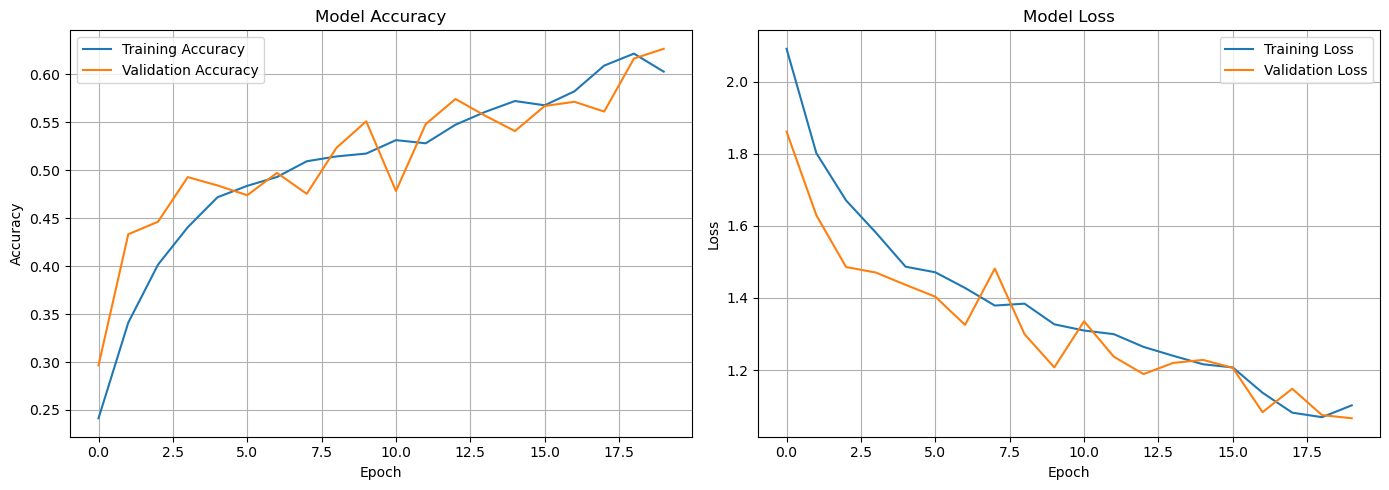


--------------------------------------------------
BASELINE MODEL PERFORMANCE
Final Training Accuracy: 0.6027
Final Validation Accuracy: 0.6265
Final Training Loss: 1.1020
Final Validation Loss: 1.0663
--------------------------------------------------


In [ ]:
# Plot Results
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Final Performance
print("\n" + "-"*50)
print("BASELINE MODEL PERFORMANCE")
print("="*50)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print("-"*50)